In [0]:
# Installing cplex
!pip install cplex
import cplex

     |████████████████████████████████| 31.0MB 140kB/s 


In [0]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [0]:
# Import Libraries
import pandas as pd
import numpy as np
import time
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC

In [0]:
def visualize(datafile):
  # Load dataset
  data = arff.loadarff(datafile)
  dataset = pd.DataFrame(data[0])

  # Quick view
  print("Shape =", dataset.shape,'\n')
  print(dataset.shape[0],' examples,',dataset.shape[1]-1,' features', ' and 1 target class \n')
  print(dataset.head(),'\n')
  print(dataset.describe().T,'\n')

  # Checking the balance of the data by plotting the count of targets by their value
  plt.rcParams['figure.figsize']=(10,10)
  print("Balance : \n", dataset.target.value_counts(),'\n')
  
  # View the correlation matrix
  corr = dataset.corr()
  sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

  # View the repartition of patients based on each feature
  for column in dataset.columns:
    g = sns.FacetGrid(dataset, col='target')
    g.map(plt.hist, column, bins=20)


Shape = (768, 9) 

768  examples, 8  features  and 1 target class 

   timespreg  gluctol  diaspb  triceps  ...  massindex  pedigree   age  target
0        6.0    148.0    72.0     35.0  ...       33.6     0.627  50.0    b'2'
1        1.0     85.0    66.0     29.0  ...       26.6     0.351  31.0    b'1'
2        8.0    183.0    64.0      0.0  ...       23.3     0.672  32.0    b'2'
3        1.0     89.0    66.0     23.0  ...       28.1     0.167  21.0    b'1'
4        0.0    137.0    40.0     35.0  ...       43.1     2.288  33.0    b'2'

[5 rows x 9 columns] 

           count        mean         std  ...       50%        75%     max
timespreg  768.0    3.845052    3.369578  ...    3.0000    6.00000   17.00
gluctol    768.0  120.894531   31.972618  ...  117.0000  140.25000  199.00
diaspb     768.0   69.105469   19.355807  ...   72.0000   80.00000  122.00
triceps    768.0   20.536458   15.952218  ...   23.0000   32.00000   99.00
insulin    768.0   79.799479  115.244002  ...   30.5000  12

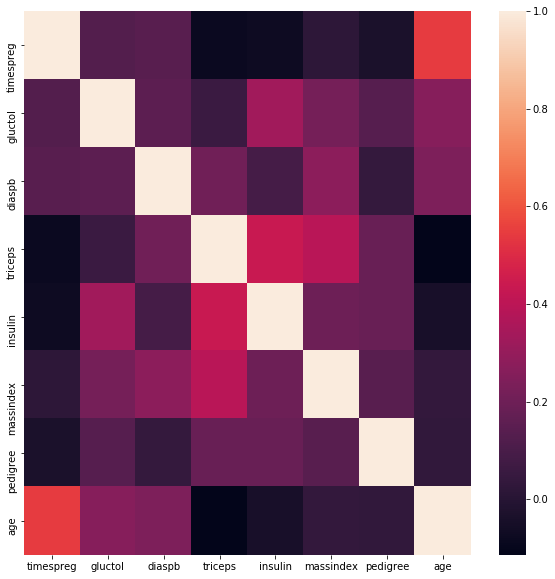

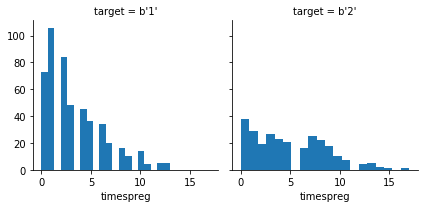

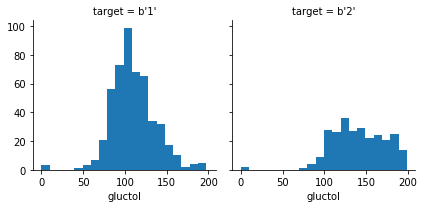

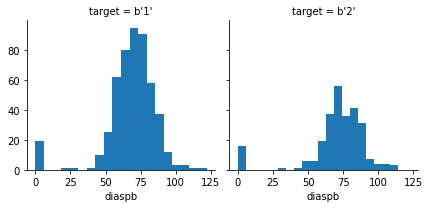

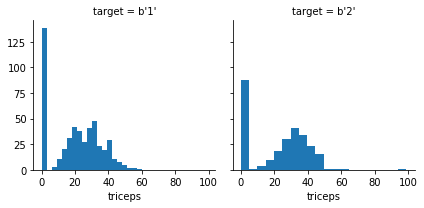

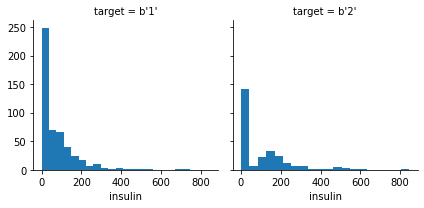

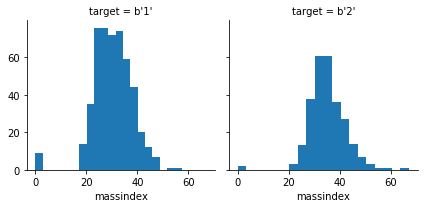

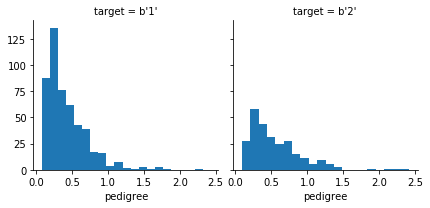

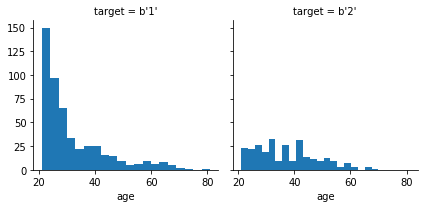

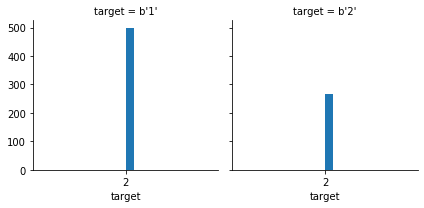

In [0]:
visualize('diabetes.txt')

In [0]:
def preprocess(datafile, n_max = 500, standardization = True, dim = 1, random_seed = None):
  # Load Data
  data = arff.loadarff(datafile)
  dataset = pd.DataFrame(data[0])

  # Change type of 'target' from object to integer
  dataset.target=dataset.target.astype(int)

  # Change value of 'target' from {1,2} to {-1,1}
  dataset.target=dataset.target.replace(2,-1)

  # Cut the dataset if too large
  if dataset.shape[0]> n_max:
    dataset=dataset.iloc[:n_max]
  
  # Dividing the dataset into training set and validation set
  dataset_train, dataset_test= train_test_split(dataset, test_size=0.2, random_state = random_seed)

  # Correcting outliers
  for c in dataset_train.columns:
    dataset_train.loc[dataset_train[c]>dataset_train[c].mean()+2*dataset_train[c].std(),c]=dataset_train[c].mean()+2*dataset_train[c].std()
    dataset_train.loc[dataset_train[c]<dataset_train[c].mean()-2*dataset_train[c].std(),c]=dataset_train[c].mean()-2*dataset_train[c].std()

  # Split labels Y and features X of the dataset
  y_train=dataset_train['target']
  y_test=dataset_test['target']
  X_train=dataset_train[dataset_train.columns[:dataset.shape[1]-1]]
  X_test=dataset_test[dataset_test.columns[:dataset.shape[1]-1]]

  # Scaling the data
  if standardization==True:
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform (X_test)
  else :
    X_train=X_train.to_numpy()
    X_test=X_test.to_numpy()

  y_train=y_train.to_numpy()
  y_test=y_test.to_numpy()
  
  if dim>1:
    poly = PolynomialFeatures(dim,include_bias=False)
    X_train=poly.fit_transform(X_train)
    X_test=poly.fit_transform(X_test)

  return X_train, X_test, y_train, y_test

In [0]:
def MatrixToList(Mat):
    MatList = []
    for i in range(Mat.shape[1]):
        MatList.append([range(Mat.shape[1]), (Mat[i]).tolist()])
    return MatList

In [0]:
def flatten(alist):
    if alist == []:
        return []
    elif type(alist) is not list:
        return [alist]
    else:
        return flatten(alist[0]) + flatten(alist[1:])

**Class CustomSVM** 

Attributes : 


*   C (int) : C parameter 
*   time_limit (int) : max time allowed to solve problem (in sec)

*   loss (str) : "ramp" or "hard_margin"

Methodes : 


*   __init__
*   fit


*   predict
*   score








In [0]:
# SVM implementation using CPLEX Python API

class CustomSVM():

    def __init__(self, loss="ramp", C=1.0, time_limit = False): 
        self.loss = loss
        if loss != "ramp" and loss != "hard_margin":
          raise ValueError('loss should be equal to "ramp" or "hard_margin"')
        self.time_limit = time_limit
        self.C = C
        self.p = cplex.Cplex()
 
    # Fit a training set and solve a binary classification problem using svm ramp or hard_margin loss
    def fit(self, X_train, y_train):

        if self.loss=="ramp":
          
          self.p.set_problem_name("SVM_RL")
      
          self.p.objective.set_sense(self.p.objective.sense.minimize)
      
          my_colnames = [["w" + str(i) for i in range(1, X_train.shape[1] + 1)], ["b"],
                          ["E" + str(i) for i in range(1, X_train.shape[0] + 1)],
                            ["z" + str(i) for i in range(1, X_train.shape[0] + 1)]]

          self.p.variables.add(types = [self.p.variables.type.continuous] * len(my_colnames[0]),
                          names = my_colnames[0], lb=[- cplex.infinity]*len(my_colnames[0]))
                      
          qmat = MatrixToList(np.identity(X_train.shape[1]))

          self.p.objective.set_quadratic(qmat)  
          
          self.p.variables.add(obj=[0], types = [self.p.variables.type.continuous], names=["b"], lb=[- cplex.infinity])
      
          self.p.variables.add(obj=[self.C] * len(my_colnames[2]),
                          types = [self.p.variables.type.continuous] * len(my_colnames[2]), names = my_colnames[2],
                          lb=[0] * len(my_colnames[2]), ub=[2] * len(my_colnames[2]))

          self.p.variables.add(obj=[2*self.C] * len(my_colnames[3]),
                      types = [self.p.variables.type.binary] * len(my_colnames[3]),
                      names = my_colnames[3])
      
          coefs = []
          for i in range(X_train.shape[0]):
              coefs.append([y_train[i] * X_train[i], y_train[i], 1.0])
              coefs[i][0] = coefs[i][0].tolist()
      
          wlist = my_colnames[0]
          Elist = my_colnames[2]
      
          for n in range(X_train.shape[0]):
              inds = list(flatten([wlist, "b", Elist[n]]))
              fcoefs=np.asarray(flatten(coefs[n]))
              self.p.indicator_constraints.add(indvar= my_colnames[3][n], complemented=1,
                                      rhs=1.0, sense='G',
                                      lin_expr=cplex.SparsePair(ind=inds, val=fcoefs))
        elif self.loss=="hard_margin":

          self.p.set_problem_name("SVM_HM")

          self.p.objective.set_sense(self.p.objective.sense.minimize)

          my_colnames = [["w" + str(i) for i in range(1, X_train.shape[1] + 1)], ["b"],
                        ["z" + str(i) for i in range(1, X_train.shape[0] + 1)]]

          self.p.variables.add(types = [self.p.variables.type.continuous] * len(my_colnames[0]),
                          names = my_colnames[0])
                      
          qmat = MatrixToList(np.identity(X_train.shape[1]))

          self.p.objective.set_quadratic(qmat)  

          self.p.variables.add(obj=[0], types =self.p.variables.type.continuous, names=["b"])


          self.p.variables.add(obj=[self.C] * len(my_colnames[2]),
                      types = [self.p.variables.type.binary] * len(my_colnames[2]),
                      names = my_colnames[2])

          coefs = []
          for i in range(X_train.shape[0]):
              coefs.append([y_train[i] * X_train[i], y_train[i]])
              coefs[i][0] = coefs[i][0].tolist()

          wlist = my_colnames[0]

          for n in range(X_train.shape[0]):
              inds = list(flatten([wlist, "b"]))
              fcoefs=np.asarray(flatten(coefs[n]))
              self.p.indicator_constraints.add(indvar= my_colnames[2][n], complemented=1,
                                      rhs=1.0, sense='G',
                                      lin_expr=cplex.SparsePair(ind=inds, val=fcoefs))
        if self.time_limit != False:      
          self.p.parameters.timelimit.set(self.time_limit)
        self.p.parameters.mip.cuts.localimplied.set(-1)
        self.p.set_results_stream(None)
        self.p.solve()

        return self

    # Use it after fitting a traning set to predict class of a test set using solved problem of method fit  
    def predict(self, X_test):

        sol = self.p.solution

        Y_pred = np.zeros(shape=X_test.shape[0])
            
        sol_vals = []
        
        for i in range(X_train.shape[1] + 1):
            sol_vals.append(sol.get_values(i))
        
        w = np.asarray(sol_vals[0:len(sol_vals)-1])
        b = sol_vals[len(sol_vals)-1]
        
        for j in range(X_test.shape[0]):
            Y_pred[j] = np.sign(np.inner(w, X_test[j]) + b)
              
        return Y_pred

    # Predict and score the prediction on a test set (use it after fitting a problem)
    def score(self, X_test, y_test, measure="accuracy"):

        sol = self.p.solution

        Y_pred = np.zeros(shape=y_test.shape[0])
            
        sol_vals = []
        
        for i in range(X_test.shape[1] + 1):
            sol_vals.append(sol.get_values(i))
        
        w = np.asarray(sol_vals[0:len(sol_vals)-1])
        b = sol_vals[len(sol_vals)-1]
        
        for j in range(X_test.shape[0]):
            Y_pred[j] = np.sign(np.inner(w, X_test[j]) + b)

        #Compute confusion matrix
        
        TP = np.zeros(shape=y_test.shape[0])
        TN = np.zeros(shape=y_test.shape[0])
        FP = np.zeros(shape=y_test.shape[0])
        FN = np.zeros(shape=y_test.shape[0])
        
        for i in range(y_test.shape[0]):
            if y_test[i] == 1 and Y_pred[i] == 1:
                TP[i] = 1
            elif y_test[i] == 1 and Y_pred[i] == -1:
                FN[i] = 1
            elif y_test[i] == -1 and Y_pred[i] == 1:    
                FP[i] = 1
            elif y_test[i] == -1 and Y_pred[i] == -1:
                TN[i] = 1
        
        Confusion_matrix = [[np.sum(TP), np.sum(FN)], [np.sum(FP), np.sum(TN)]]        
        sensitivity = Confusion_matrix[0][0] / (Confusion_matrix[0][0] + Confusion_matrix[0][1])
        precision = Confusion_matrix[0][0] / (Confusion_matrix[0][0] + Confusion_matrix[1][0])
        accuracy = (Confusion_matrix[0][0] + Confusion_matrix[1][1]) / (Confusion_matrix[0][0] + 
                    Confusion_matrix[1][1] + Confusion_matrix[0][1] + Confusion_matrix[1][0])   
        
        if measure=="confusion_matrix":
          return Confusion_matrix
        if measure=="precision":
          return precision
        if measure=="sensitivity":
          return sensitivity
        return accuracy

method **gridsearch**

*Use it to test multiples crossed SVM settings*

**Arguments :** 


  **datafiles (str array[])** : nom des fichiers des data sets à tester

  **n_max (int)** : nombre maximum d’exemples dans pour chacun des data sets

  **paramC (int arry[])** : tableau contenant les valeurs de C à tester

  **time_limit(int)** : le temps de calcul maximum d’un apprentissage en seconde (par défaut il n’y en a pas)

  **random (bool)** : Si random = true alors à chaque exécution la division train/test set est effectuée de façon complètement aléatoire sinon elle suit pour chaque exécution le random seed égal au numéro de l’exécution

  **RUNS (int)** : le nombre d’exécution voulues

In [0]:
def gridsearch(datafiles, paramC, time_limit = False, n_max = 500, random = True, RUNS = 1):

  scores = []

  for run in range(RUNS) : 

    #print("Run = ", run+1,"/",RUNS)

    for datafile in datafiles:

      if random == True :
        X_train, X_test, y_train, y_test = preprocess(datafile, n_max = n_max)
      else : 
        X_train, X_test, y_train, y_test = preprocess(datafile, n_max = n_max, random_seed = run)

      for C in paramC:

        st = time.time()
        hinge = svm.LinearSVC(C = C, loss = "hinge")
        hinge.fit(X_train,y_train)
        scores.append([run, datafile, "hinge", C, hinge.score(X_train,y_train), hinge.score(X_test,y_test), time.time()-st])
        
        st = time.time()
        ramp = CustomSVM(loss = "ramp", C = C, time_limit = time_limit)
        ramp.fit(X_train, y_train)
        scores.append([run, datafile, "ramp", C, ramp.score(X_train, y_train), ramp.score(X_test,y_test,measure='precision'), time.time()-st])

        st = time.time()
        hard_margin = CustomSVM(loss = "hard_margin", C = C, time_limit = time_limit)
        hard_margin.fit(X_train, y_train)
        scores.append([run, datafile, "hard_margin", C, hard_margin.score(X_train,y_train), hard_margin.score(X_test,y_test), time.time()-st])

  results = pd.DataFrame(scores,columns=['run','dataset','loss', 'C', 'score_train', 'score_test','time'])
  results = results.groupby(['dataset','loss', 'C'])['score_train', 'score_test','time'].mean()
  return results

In [0]:
# Use gridsearch example 
param = [0.001,0.01,0.1,1,10,100,1000]
datafiles = ["diabetes.txt", "liver.txt", "heart-bin.txt"]
r = gridsearch(datafiles, param, time_limit = 20, n_max = 50, random = False, RUNS = 10)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(r)

                                    score_train  score_test       time
dataset       loss        C                                           
diabetes.txt  hard_margin 0.001          0.5075        0.47   0.043880
                          0.010          0.5075        0.47   0.052831
                          0.100          0.5075        0.47   0.101730
                          1.000          0.5100        0.45   0.564333
                          10.000         0.5600        0.36   4.653457
                          100.000        0.5825        0.38   4.687718
                          1000.000       0.5875        0.39   6.312807
              hinge       0.001          0.6875        0.63   0.001222
                          0.010          0.6900        0.63   0.001361
                          0.100          0.7525        0.61   0.001398
                          1.000          0.7650        0.66   0.001603
                          10.000         0.7800        0.66   0.002171
      

Method **timesolving**

*Use it to determine the computation time of solving svm (ramp or hard_margin loss) based on the number of examples of the dataset*

***Arguments :*** 

**Datafile (str)** : nom du fichier du dataset

**Loss (str)** : nom de la fonction de loss, ‘hard_margin’ / ‘ramp’ 

**n_max ( int array[] )** : tableau contenant les différentes tailles n à tester du dataset

**time_limit(int)** : le temps de calcul maximum d’une exécution en seconde

**RUNS (int)** : le nombre d’exécutions pour chaque valeur de n



In [0]:
def timesolving(datafile, loss, n_max, time_limit = 600, RUNS = 1):
  scores = []
  for run in range(RUNS) : 

    #print("Run = ", run+1,"/",RUNS)
    for n in n_max:

      X_train, X_test, y_train, y_test = preprocess(datafile, n_max = n)

      if loss == 'ramp':
    
        st = time.time()
        ramp = CustomSVM(loss = "ramp", time_limit = time_limit)
        ramp.fit(X_train, y_train)
        scores.append([run, datafile, "ramp", n, time.time()-st])

      if loss == 'hard_margin':

        st = time.time()
        hard_margin = CustomSVM(loss = "hard_margin", time_limit = time_limit)
        hard_margin.fit(X_train, y_train)
        scores.append([run, datafile, "hard_margin", n, time.time()-st])

  results = pd.DataFrame(scores,columns=['run','dataset','loss', 'n', 'time'])
  results = results.groupby(['loss', 'n'])['time'].mean()
  return results

In [0]:
# Use timesolving example
n_max=[10,20,50,70,100,110,120,150,170,200]
times = timesolving('diabetes.txt', 'hard_margin', n_max, time_limit = 600)
times

loss         n  
hard_margin  10       0.013487
             20       0.041512
             50       0.431235
             70       0.743453
             100      1.079733
             110     13.416460
             120     32.914783
             150    600.019925
             170    590.616507
             200    600.023708
Name: time, dtype: float64

methode **polysearch**

*use it to determine the best dimension of a dataset to use with SVM*

***Arguments : ***

**datafiles (str array[])** : nom des fichiers des data sets à tester

**n_max (int)** : nombre maximal d’exemples dans pour chacun des data sets

**dim(int arry[])** : tableau contenant les valeurs de dimensions à tester

**RUNS (int)** : le nombre d’exécution voulues



In [0]:
def polysearch(datafiles, dim, RUNS = 1):
  scores=[]
  for run in range(RUNS) : 
    #print("Run = ", run+1,"/",RUNS)
    for datafile in datafiles:
      X_train, X_test, y_train, y_test = preprocess(datafile, n_max = 1000)
      for deg in dim:
        svc = SVC(kernel = 'poly', degree = deg, coef0 = 1).fit(X_train,y_train)
        score_test = svc.score(X_test, y_test)
        score_train = svc.score(X_train, y_train)
        scores.append([datafile,deg,score_train,score_test])
  results = pd.DataFrame(scores,columns=['dataset', 'dim', 'score_train', 'score_test'])
  results = results.groupby(['dataset', 'dim'])['score_train','score_test'].mean()
  return results


In [0]:
# Use polysearch example
t=polysearch(["diabetes.txt", "liver.txt", "heart-bin.txt","bc-orig.txt","sonar.txt"],[1,2,3,5,7,10],100)
print(t)

                   score_train  score_test
dataset       dim                         
bc-orig.txt   1       0.971648    0.969270
              2       0.976685    0.966642
              3       0.981722    0.959197
              5       0.994432    0.947153
              7       0.999615    0.938467
              10      1.000000    0.932920
diabetes.txt  1       0.778160    0.770195
              2       0.796401    0.756948
              3       0.837622    0.736883
              5       0.930586    0.704805
              7       0.983681    0.674610
              10      0.999511    0.661818
heart-bin.txt 1       0.865833    0.839074
              2       0.917176    0.816296
              3       0.961111    0.790741
              5       0.999815    0.758889
              7       1.000000    0.753333
              10      1.000000    0.760926
liver.txt     1       0.716703    0.668116
              2       0.787754    0.720580
              3       0.823696    0.695217
           

In [0]:
def polysearchrbf(datafiles, dim, RUNS = 1):
  scores=[]
  for run in range(RUNS) : 
    #print("Run = ", run+1,"/",RUNS)
    for datafile in datafiles:
      X_train, X_test, y_train, y_test = preprocess(datafile, n_max = 1000)
      for deg in dim:
        svc = SVC(kernel = 'poly', degree = deg, coef0 = 1).fit(X_train,y_train)
        rbf = SVC(kernel = 'rbf').fit(X_train,y_train)
        score_test = svc.score(X_test, y_test)
        score_test_rbf = rbf.score(X_test, y_test)
        score_train = svc.score(X_train, y_train)
        scores.append([datafile,deg,score_train,score_test,score_test_rbf])
  results = pd.DataFrame(scores,columns=['dataset', 'dim', 'score_train', 'score_test', 'score_rbf'])
  results = results.groupby(['dataset', 'dim'])['score_train','score_test','score_rbf'].mean()
  return results

In [0]:
t2=polysearchrbf(["diabetes.txt", "liver.txt", "heart-bin.txt","bc-orig.txt","sonar.txt"],[1,2,3,5,7,10],10)
print(t2)

                   score_train  score_test  score_rbf
dataset       dim                                    
bc-orig.txt   1       0.970330    0.975912   0.970073
              2       0.975275    0.975182   0.970073
              3       0.980403    0.963504   0.970073
              5       0.994322    0.953285   0.970073
              7       0.999634    0.942336   0.970073
              10      1.000000    0.937956   0.970073
diabetes.txt  1       0.778176    0.771429   0.764286
              2       0.791694    0.768182   0.764286
              3       0.836645    0.750000   0.764286
              5       0.927036    0.700649   0.764286
              7       0.982410    0.683766   0.764286
              10      0.999511    0.670779   0.764286
heart-bin.txt 1       0.872685    0.812963   0.790741
              2       0.922222    0.800000   0.790741
              3       0.966204    0.753704   0.790741
              5       1.000000    0.725926   0.790741
              7       1.0000

In [0]:
# Function to visualize svm margin 

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

def visualize_svm(datafile, paramC, standardization = True):

  # data preprocessing
  X_train, X_test, y_train, y_test = preprocess(datafile, standardization = standardization)

  # pca to have only 2 main features
  pca = PCA(n_components=2)
  X = pca.fit_transform(X_train)
  y = y_train

  # fit and plot the model
  fig, ax = plt.subplots(1, 2, figsize=(16, 6))
  fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

  for axi, C in zip(ax, paramC):
      model = SVC(kernel='linear', C=C).fit(X, y)
      axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
      plot_svc_decision_function(model, axi)
      axi.scatter(model.support_vectors_[:, 0],
                  model.support_vectors_[:, 1],
                  s=300, lw=1, facecolors='none');
      axi.set_title('C = {0:.1f}'.format(C), size=14)

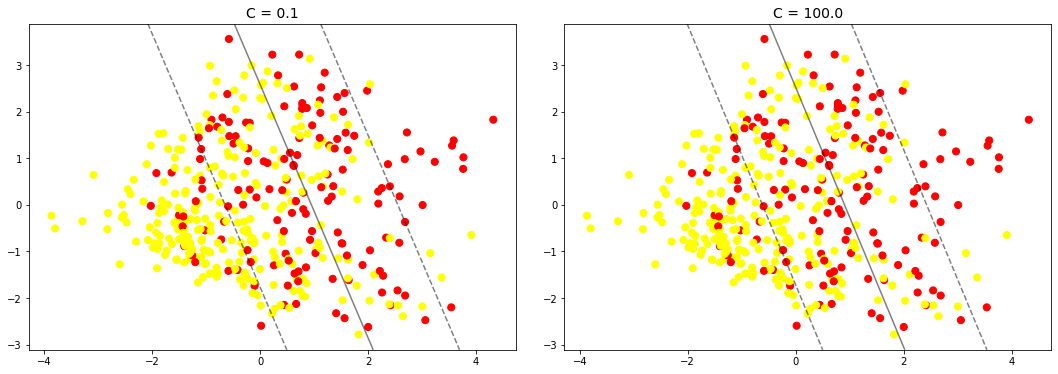

In [0]:
visualize_svm('diabetes.txt', [0.1,100], standardization = True)

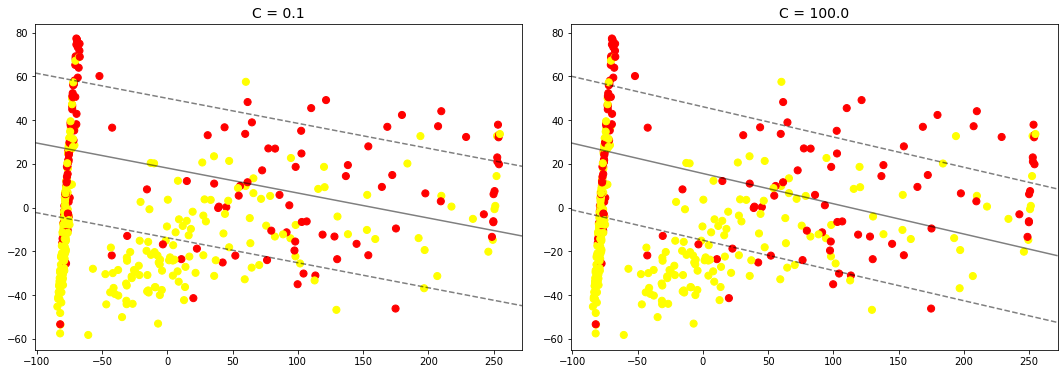

In [0]:
visualize_svm('diabetes.txt', [0.1,100], standardization = False)